# Set-up workspace

Read in Python packages and mount Google Drive to connect with files. 

In [16]:
import os

In [17]:
from google.colab import drive #import drive from google colab
ROOT = "/content/drive" # default location for the drive
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/My Drive/EEOB590A/')

Install rpy2 and R packages to access R libraries and functions. 

In [4]:
!apt-get install r-base
!pip install -q rpy2
packnames = ("tidyverse", "lme4", "lmerTest", "emmeans", 
             "ggResidpanel", "data.table", "stringr")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.1.2-1.1804.0).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘later’, ‘DEoptimR’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘robustbase’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘numDeriv’, ‘estimability’, ‘mvtnorm’, ‘xtable’, ‘cowplot’, ‘plotly’, ‘qqplotr’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/later_1.3.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 63785 bytes (62 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f5aa02b1e60> [RTYPES.NILSXP]

In [19]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [20]:
%%R
library("tidyverse"); theme_set(theme_bw())
library("lme4")
library("lmerTest")
library("emmeans")
library("ggResidpanel")
library("data.table")
library("stringr")

# Data Analysis

In [21]:
%%R
flume <- read_csv("./data/tidy/flume_sub.csv",
                  col_types = cols(
                  Year = col_double(),
                  SiteID = col_character(),
                  Treatment = col_character(),
                  date = col_date(),
                  weight = col_double(),
                  flow_mm = col_double(),
                  rain_mm = col_double(),
                  TSS_ppm = col_double()
                  ))

flumeNA <- read_csv("./data/tidy/flume.csv",
                    col_types = cols(
                        Year = col_double(),
                        SiteID = col_character(),
                        Treatment = col_character(),
                        date = col_date(),
                        weight = col_double(),
                        flow_mm = col_double(),
                        rain_mm = col_double(),
                        TSS_ppm = col_double()
                        )) %>%
                        filter(!is.na(TSS_ppm))

weight <- read_csv("./data/tidy/weight.csv",
                   na = c("NA","NaN"),
                   col_types = cols(
                        Year = col_double(),
                        SiteID = col_character(),
                        Position = col_character(),
                        Time = col_double(),
                        PadID = col_character(),
                        weight = col_double(),
                        Mppt = col_double(),
                        Days = col_double(),
                        wpd = col_double()
                        )) %>%
                        filter(!is.na(weight)) 

## Flume analysis

Analyze treatment effects using flume data between 2016-2019. Daily TSS load between March and November. 

In [22]:
%%R
m1_flume <- lmerTest::lmer(TSS_ppm ~ 
           factor(Year) * Treatment +
           (1 | SiteID),
           #(1 | SiteID:Treatment) # Remove due to singularity
           data = flume)

In [10]:
%%R
g = resid_panel(m1_flume, plots = c("resid","index","yvp","qq"),
            smoother = TRUE, qqbands = TRUE)

ggsave("./graphics/flume_resid_panel.png", g, width = 12, height = 12)

R[write to console]: `geom_smooth()` using formula 'y ~ x'

R[write to console]: `geom_smooth()` using formula 'y ~ x'



In [11]:
%%R
h = resid_xpanel(m1_flume)

ggsave("./graphics/flume_resid_xpanel.png", h, width = 12, height = 12)

In [12]:
%%R
m1_step <- step(m1_flume, reduce.random = FALSE)

Data needs to be log-transformed due data being skewed and not meeting the assumptions of normality and constant variance.

In [26]:
%%R
m2_flume <- lmerTest::lmer(log(TSS_ppm) ~ 
           factor(Year) * Treatment +
           (1 | SiteID),
           #(1 | SiteID:Treatment), # removed due to singularity
           data = flume)

In [14]:
%%R
m2_flume_step <- step(m2_flume, reduce.random = FALSE)
m2_flume_step

Backward reduced random-effect table:

             Eliminated npar  logLik    AIC    LRT Df Pr(>Chisq)    
<none>                    10 -391.19 802.38                         
(1 | SiteID)          0    9 -397.24 812.48 12.094  1  0.0005059 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Backward reduced fixed-effect table:
Degrees of freedom method: Satterthwaite 

                       Eliminated  Sum Sq Mean Sq NumDF  DenDF F value   Pr(>F)
factor(Year):Treatment          1  69.186  23.062     3 142.46  2.4028 0.070115
Treatment                       2  34.368  34.368     1 145.88  3.4835 0.063990
factor(Year)                    0 199.832  66.611     3 149.91  6.6265 0.000311
                          
factor(Year):Treatment .  
Treatment              .  
factor(Year)           ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Model found:
log(TSS_ppm) ~ factor(Year) + (1 | SiteID)


In [ ]:
%%R
m2_flume_step <- get_model(m2_flume_step)
summary(m2_flume_step)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(TSS_ppm) ~ (1 | SiteID) + Treatment + (1 | SiteID:Treatment) +  
    factor(Year) * Treatment
   Data: flume

REML criterion at convergence: 1931.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2444 -0.5067  0.1226  0.7267  2.0627 

Random effects:
 Groups           Name        Variance Std.Dev.
 SiteID:Treatment (Intercept) 0.4815   0.6939  
 SiteID           (Intercept) 0.5510   0.7423  
 Residual                     7.5884   2.7547  
Number of obs: 396, groups:  SiteID:Treatment, 12; SiteID, 6

Fixed effects:
                                  Estimate Std. Error        df t value
(Intercept)                       -0.08829    0.61904  19.83735  -0.143
Treatmentstrips                   -2.08790    0.87672  18.92746  -2.381
factor(Year)2017                   1.02961    0.69641 382.56923   1.478
factor(Year)2018                  -0.94689    0.55015 387.47373  -1.721
facto

R[write to console]: `geom_smooth()` using formula 'y ~ x'

R[write to console]: `geom_smooth()` using formula 'y ~ x'



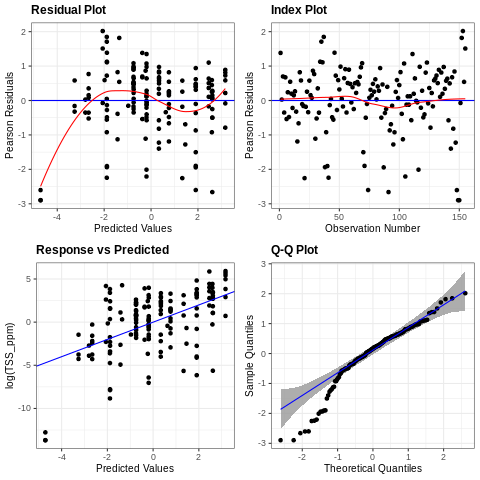

In [27]:
%%R
gNA = resid_panel(m2_flume, plots = c("resid","index","yvp","qq"),
            smoother = TRUE, qqbands = TRUE)

ggsave("./graphics/flume_resid_xpanel.png", h, width = 12, height = 12)

In [ ]:
%%R
resid_xpanel(m2_flume)

Analyze treatment effects using flume data between 2016-2019. Daily TSS load measured during mesh pad sampling periods. 

In [ ]:
%%R
m1_sub <- lmerTest::lmer(TSS_ppm ~ 
           factor(Year) * Treatment +
           (1 | SiteID) + 
           # (1 | SiteID:Treatment), # removed due to singularity
           data = flume_sub)

In [ ]:
%%R
resid_panel(m1_sub, plots = c("resid","index","yvp","qq"),
            smoother = TRUE, qqbands = TRUE)

In [ ]:
%%R
resid_xpanel(m1_sub)

In [ ]:
%%R
m2_sub <- lmerTest::lmer(log(TSS_ppm) ~ 
           factor(Year) * Treatment +
           (1 | SiteID),
           # (1 | SiteID:Treatment) # removed due singularity
           data = flume_sub)

R[write to console]: boundary (singular) fit: see ?isSingular



R[write to console]: `geom_smooth()` using formula 'y ~ x'

R[write to console]: `geom_smooth()` using formula 'y ~ x'



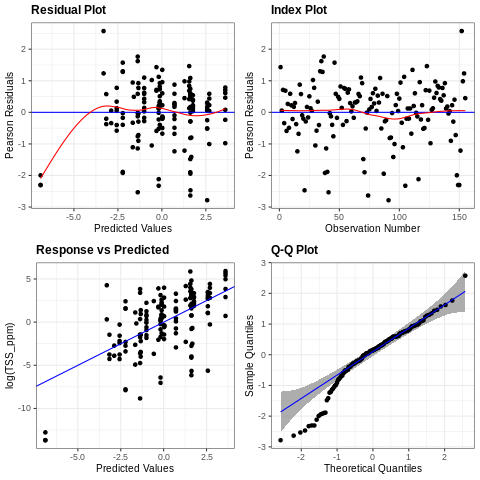

In [ ]:
%%R
resid_panel(m2_sub, plots = c("resid","index","yvp","qq"),
            smoother = TRUE, qqbands = TRUE)

In [ ]:
%%R
resid_xpanel(m2_sub)

In [ ]:
%%R
m2_sub_step <- step(m2_sub, reduce.random = FALSE)
m2_sub_step

R[write to console]: boundary (singular) fit: see ?isSingular



Backward reduced random-effect table:

                       Eliminated npar  logLik    AIC    LRT Df Pr(>Chisq)  
<none>                              11 -388.02 798.04                       
(1 | SiteID)                    0   10 -388.02 796.04 0.0000  1    1.00000  
(1 | SiteID:Treatment)          0   10 -391.19 802.38 6.3399  1    0.01181 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Backward reduced fixed-effect table:
Degrees of freedom method: Satterthwaite 

                       Eliminated  Sum Sq Mean Sq NumDF   DenDF F value
Treatment:factor(Year)          1  56.110  18.703     3 145.593  2.1529
Treatment                       2   0.999   0.999     1   8.402  0.1124
factor(Year)                    0 162.032  54.011     3 143.272  6.0702
                          Pr(>F)    
Treatment:factor(Year) 0.0961444 .  
Treatment              0.7456058    
factor(Year)           0.0006423 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

M

In [ ]:
%%R
summary(m2_sub)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(TSS_ppm) ~ (1 | SiteID) + Treatment + (1 | SiteID:Treatment) +  
    factor(Year) * Treatment
   Data: flume_sub

REML criterion at convergence: 776

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7833 -0.3850  0.1411  0.5879  2.5745 

Random effects:
 Groups           Name        Variance Std.Dev.
 SiteID:Treatment (Intercept) 5.469    2.339   
 SiteID           (Intercept) 0.000    0.000   
 Residual                     8.688    2.947   
Number of obs: 155, groups:  SiteID:Treatment, 12; SiteID, 6

Fixed effects:
                                  Estimate Std. Error        df t value
(Intercept)                       -0.06627    1.48350  31.43588  -0.045
Treatmentstrips                   -1.98596    2.10215  30.60233  -0.945
factor(Year)2017                   1.02331    1.30955 138.58369   0.781
factor(Year)2018                  -1.64874    1.27847 144.95388  -1.290
fact

In [ ]:
%%R
m3_sub <- lmerTest::lmer(sqrt(TSS_ppm) ~ 
           factor(Year) * Treatment +
           (1 | SiteID) + 
           (1 | SiteID:Treatment),
           data = flume_sub)

In [ ]:
%%R
resid_panel(m3_sub, plots = c("resid","index","yvp","qq"),
            smoother = TRUE, qqbands = TRUE)

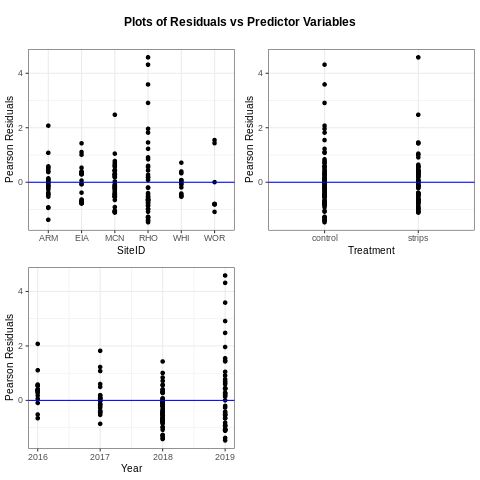

In [ ]:
%%R
resid_xpanel(m3_sub)

In [ ]:
%%R
m3_sub_step <- step(m3_sub, reduce.random = FALSE)
m3_sub_step

## Pad analysis

In [ ]:
%%R
m1_pad <- 
  lmerTest::lmer(wpd ~ 
           Position +
           Treatment * Position +
           factor(Year) * Treatment +
           (1 | SiteID) +
           (1 | SiteID:Treatment) + 
           #(1 | SiteID:Treatment:Position) + # removed due to singularity
           (1|SiteID:Treatment:Position:Time),
         data = weight)

In [ ]:
%%R
resid_panel(m1_pad, plots = c("resid","index","yvp","qq"),
            smoother = TRUE, qqbands = TRUE)

In [ ]:
%%R
resid_xpanel(m1_pad)

In [ ]:
%%R
m2_pad <- 
  lmerTest::lmer(log(wpd+0.002) ~ 
           Treatment +
           Position +
           Treatment * Position +
           factor(Year) * Treatment +
           (1 | SiteID) + 
           (1 | SiteID:Treatment) +
           # (1 | SiteID:Treatment:Position) + # removed due to singularity
           (1|SiteID:Treatment:Position:Time),
         data = weight)

In [ ]:
%%R
resid_panel(m2_pad, plots = c("resid","index","yvp","qq"),
            smoother = TRUE, qqbands = TRUE)

In [ ]:
%%R
resid_xpanel(m2_pad)

In [ ]:
%%R
m2_pad_step <- step(m2_pad, reduce.random = FALSE)
m2_pad_step

In [ ]:
%%R
m2_pad_step <- get_model(m2_pad_step)
summary(m2_pad_step)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
log(wpd + 0.002) ~ (1 | SiteID) + Treatment + (1 | SiteID:Treatment) +  
    (1 | SiteID:Treatment:Position) + factor(Year) + (1 | SiteID:Treatment:Position:Time) +  
    Treatment:factor(Year)
   Data: weight

REML criterion at convergence: 11259.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8925 -0.6295 -0.0796  0.5718  4.6384 

Random effects:
 Groups                         Name        Variance Std.Dev.
 SiteID:Treatment:Position:Time (Intercept) 0.12912  0.3593  
 SiteID:Treatment:Position      (Intercept) 0.02012  0.1419  
 SiteID:Treatment               (Intercept) 0.04026  0.2006  
 SiteID                         (Intercept) 0.75378  0.8682  
 Residual                                   1.44095  1.2004  
Number of obs: 3453, groups:  
SiteID:Treatment:Position:Time, 108; SiteID:Treatment:Position, 36; SiteID:Treatment, 12; SiteID, 6

Fixed effects:
                

Contrasts

In [ ]:
%%R
treat_year_flume = emmeans(m2, pairwise ~ Treatment|Year,
                    type = "response", 
                    lmer.df = "asymptotic", lmerTest.limit = 5822)


confint(treat_year_flume)$contrasts

Year = 2016:
 contrast         ratio     SE  df asymp.LCL asymp.UCL
 control / strips  8.07  7.073 Inf     1.447     44.98

Year = 2017:
 contrast         ratio     SE  df asymp.LCL asymp.UCL
 control / strips 11.52 11.406 Inf     1.653     80.23

Year = 2018:
 contrast         ratio     SE  df asymp.LCL asymp.UCL
 control / strips  0.70  0.423 Inf     0.214      2.29

Year = 2019:
 contrast         ratio     SE  df asymp.LCL asymp.UCL
 control / strips  1.84  1.292 Inf     0.467      7.28

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 


In [ ]:
%%R
treat_year = emmeans(m2_sub, pairwise ~ Treatment|Year,
                    type = "response", 
                    lmer.df = "asymptotic", lmerTest.limit = 5822)


confint(treat_year)$contrasts

Year = 2016:
 contrast          ratio     SE  df asymp.LCL asymp.UCL
 control / strips  7.286 15.316 Inf    0.1183     448.6

Year = 2017:
 contrast          ratio     SE  df asymp.LCL asymp.UCL
 control / strips 26.819 55.204 Inf    0.4746    1515.5

Year = 2018:
 contrast          ratio     SE  df asymp.LCL asymp.UCL
 control / strips  0.424  0.668 Inf    0.0193       9.3

Year = 2019:
 contrast          ratio     SE  df asymp.LCL asymp.UCL
 control / strips  2.684  4.536 Inf    0.0978      73.7

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 


In [ ]:
%%R
year = emmeans(m2, ~ Year,
                  type = "response",
                  lmer.df = "satterthwaite", lmerTest.limit = 5822)

confint(year)

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



 Year response    SE    df lower.CL upper.CL
 2016    0.322 0.173 13.36    0.101     1.02
 2017    0.755 0.442 19.53    0.222     2.57
 2018    0.424 0.182  5.93    0.148     1.22
 2019    1.550 0.722  8.05    0.531     4.53

Results are averaged over the levels of: Treatment 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 


In [ ]:
%%R
treatment = emmeans(m2_sub, pairwise ~ Treatment,
                  type = "response",
                  lmer.df = "satterthwaite", lmerTest.limit = 5822)

confint(treatment)

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



$emmeans
 Treatment response    SE   df lower.CL upper.CL
 control      1.298 1.382 9.12   0.1172    14.37
 strips       0.336 0.361 9.43   0.0301     3.75

Results are averaged over the levels of: Year 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

$contrasts
 contrast         ratio   SE   df lower.CL upper.CL
 control / strips  3.86 5.84 9.27    0.128      116

Results are averaged over the levels of: Year 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 



# Data Visualization

In [ ]:
%%R
treatment <- as.data.frame(treatment)

In [ ]:
%%R
trt <-treatment %>%
  filter(contrast != "control - strips")

R[write to console]: No summary function supplied, defaulting to `mean_se()`



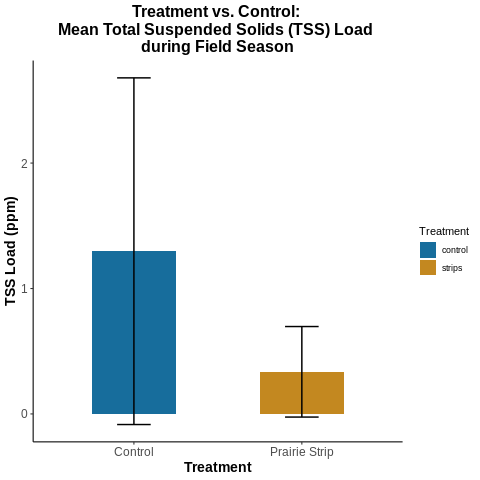

In [ ]:
%%R
trt_plot <- trt %>%
  ggplot(aes(x=Treatment, y=response, fill=Treatment))+
  theme_classic() +
  geom_bar(width = 0.5, position = position_dodge(), stat="summary") +
  geom_errorbar(aes(ymin = (response-SE), ymax = (response+SE)),
            width = 0.2,
            linetype = "solid",
            position = position_dodge(width = 0.5),
            color="black", size=0.7) +
  #scale_fill_manual(values=c('#176D9C','#C38820'), labels=c("Control","Prairie Strips")) +
  scale_fill_manual(values = c("control" = "#176D9C",
                               "strips" = "#C38820")) +
  ggtitle("Treatment vs. Control: \nMean Total Suspended Solids (TSS) Load \n during Field Season ") +
  xlab("Treatment") +
  ylab("TSS Load (ppm)") +
  theme(plot.title = element_text(size=16, face="bold", hjust=0.5),
        axis.title.x = element_text(size=14, face="bold"),
        axis.title.y = element_text(size=14, face="bold"),
        axis.text.x = element_text(size=12),
        axis.text.y = element_text(size=12)) +
  scale_x_discrete(labels= c("Control", "Prairie Strip"))

  trt_plot

In [ ]:
%%R
treat_year <- as.data.frame(treat_year)

In [ ]:
%%R
j <-treat_year %>%
  filter(contrast == "control - strips")

In [ ]:
%%R
k <-treat_year %>%
  filter(contrast != "control - strips")

R[write to console]: No summary function supplied, defaulting to `mean_se()`



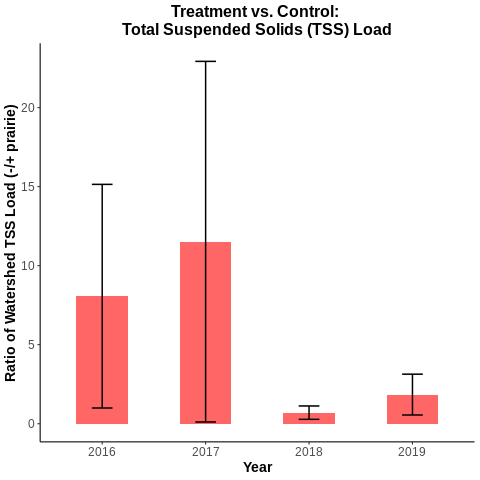

In [ ]:
%%R
treat_ratio <- j %>%
  ggplot(aes(x=Year, y=response)) +
  theme_classic() +
  geom_bar(width = 0.5, position = position_dodge(), stat="summary", fill="#FF6666") +
  geom_errorbar(aes(ymin = (response-SE), ymax = (response+SE)),
            width = 0.2,
            linetype = "solid",
            position = position_dodge(width = 0.5),
            color="black", size=0.7) +
  ggtitle("Treatment vs. Control: \nTotal Suspended Solids (TSS) Load") +
  xlab("Year") + 
  ylab("Ratio of Watershed TSS Load (-/+ prairie)") +
  theme(plot.title = element_text(size=16, face="bold", hjust=0.5),
        axis.title.x = element_text(size=14, face="bold"),
        axis.title.y = element_text(size=14, face="bold"),
        axis.text.x = element_text(size=12),
        axis.text.y = element_text(size=12))

treat_ratio

R[write to console]: No summary function supplied, defaulting to `mean_se()`



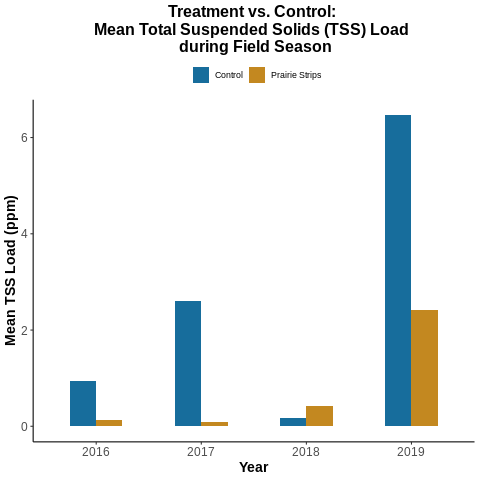

In [ ]:
%%R
treat_plot <- k %>%
  ggplot(aes(x=Year, y=response, fill=Treatment)) +
  theme_classic() +
  theme(legend.position = 'top', legend.title=element_blank()) +
  geom_bar(width = 0.5, position = position_dodge(), stat="summary") +
  #geom_errorbar(aes(ymin = (response-SE), ymax = (response+SE)),
  #          width = 0.2,
  #          linetype = "solid",
  #          position = position_dodge(width = 0.5),
  #          color="black", size=0.7) +
  scale_fill_manual(values=c('#176D9C','#C38820'), labels=c("Control","Prairie Strips")) +
  ggtitle("Treatment vs. Control: \nMean Total Suspended Solids (TSS) Load \n during Field Season") +
  xlab("Year") + 
  ylab("Mean TSS Load (ppm)") +
  theme(plot.title = element_text(size=16, face="bold", hjust=0.5),
        axis.title.x = element_text(size=14, face="bold"),
        axis.title.y = element_text(size=14, face="bold"),
        axis.text.x = element_text(size=12),
        axis.text.y = element_text(size=12))
  #scale_x_discrete(labels= c("Below Strip \n Foot Slope", "Between Strip \n Mid-Slope", "Above Strip \n Top Slope"))

treat_plot